# Self-Driving Car Nanodegree

## Project: Finding Lane Lines on the Road

In [1]:
# Import packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
import os
test_imgs = os.listdir("test_images/")

## Lane Lines on Images

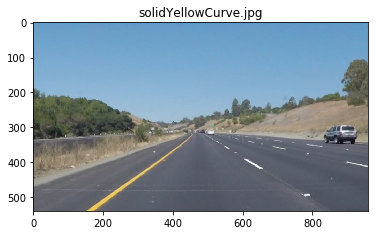

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


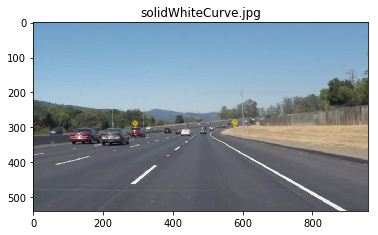

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


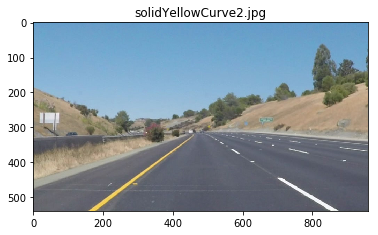

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


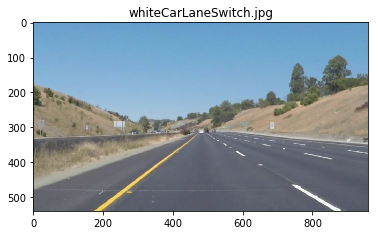

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


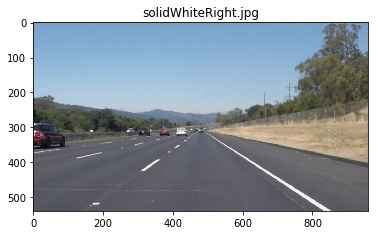

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


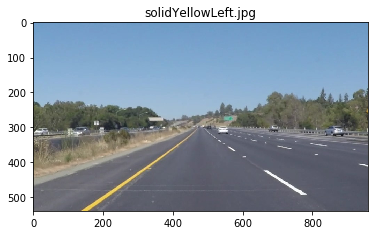

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


In [3]:
read_imgset = []

for img in test_imgs:
    image = mpimg.imread("test_images/{}".format(img))
    read_imgset.append(image)
    plt.figure()
    plt.title(img)
    plt.imshow(image)
    plt.show()
    print("The image is the type {} and the image shape {}".format(type(image), image.shape))

### Grayscale Image

In [4]:
def grayscale(img):
    """
    Applies the GrayScale transform.
    This will return an image with only one color channel
    NOTE: To view the image in grayscale you should call the following
    plt.imshow(image, cmap="gray")
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [5]:
gray_imgset = []

for img in read_imgset:
    gray = grayscale(img)
    gray_imgset.append(gray)
    # plt.figure()
    # plt.imshow(gray, cmap="gray")

### Gaussian Blur

In [6]:
def gaussian_blur(img, kernel_size):
    """ Applies a Gaussian Noise kernal"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [7]:
gaussian_imgset = []

for img in gray_imgset:
    gaussian = gaussian_blur(img = img, kernel_size=5)
    gaussian_imgset.append(gaussian)
   # plt.figure()
   # plt.imshow(gaussian, cmap="gray")

### Canny Edges

In [8]:
def canny(img, low_threshold, high_threshold):
    """ Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [9]:
canny_imgset = []

for img in gaussian_imgset:
    canny_img = canny(img, 50, 150)
    canny_imgset.append(canny_img)
   # plt.figure()
   # plt.imshow(canny_img, cmap="gray")

### Region of Interest

In [10]:
def region_of_interest(img, vertices):
    '''
    Applies an image mask.
    
    Only keep the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black
    '''
    
    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    # Defining a 3 channel or 1 channel color to fill the mask with
    # depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color=255
        
    
    # Filling the Pixels inside the polygon defined by 'vertices' with
    # the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [11]:
region_imgset = []

for img in canny_imgset:
    
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(450, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_image = region_of_interest(img, vertices)

    region_imgset.append(masked_image)
  #  plt.figure()
  #  plt.imshow(masked_image)

### Draw Lines

In [49]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):    
    """ 
    Function to draw a line
    Takes an array of hough lines and separates them by positive/
    negatives slopes.
    The y-axis is inverted in matplotlib, so the calculated positve 
    slopes will be right lanes and negative slopes will be left lanes
    Equation being used: y = mx + c; m = gradient, c = intercept
    """
    
    right_m = []
    right_c = []
    left_m = []
    left_c = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            c = y2 - m * x2
            if np.isnan(m) or np.isinf(m):
                #do nothing
                m
            elif m >= 0:
                right_m.append(m)
                right_c.append(c)
            elif m < 0:
                left_m.append(m)
                left_c.append(c)
                
    # Averaging values of slopes and y_intercepts of our left and right lines 
    # (median is used as a good measure of centre because the distribution of values are skewed)
    if not left_m:
        left_m = right_m
        left_c = right_c
    elif not right_m:
        right_m = left_m
        right_c = left_c
    
    #print(right_m, right_c)
    #print(left_m, left_c)
    right_slope = np.nanmedian(right_m)
    right_intercept = np.nanmedian(right_c)
    left_slope = np.nanmedian(left_m)
    left_intercept = np.nanmedian(left_c)
    #print(right_slope, right_intercept, left_slope, left_intercept)
    
    
    def get_points(m, c):
        y1 = img.shape[0]
        y2 = 315
        x1 = (y1 - c) / m
        x2 = (y2 - c) / m
        line = np.array([[x1, y1, x2, y2]], dtype = 'int32')
        return line
    
    # we finally get our two coordinate points for each of the left and right lines 
    lines = []
    left_line = get_points(left_slope, left_intercept)
    lines.append(left_line)
    right_line = get_points(right_slope, right_intercept)
    lines.append(right_line)
    
    # Drawing left and right lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

### Hough Transform

In [34]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """ Returns an image with hough lines drawn"""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [35]:
hough_imgset = []

for img in region_imgset:
    hough_img = hough_lines(img, rho=1, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    hough_imgset.append(hough_img)
    # plt.figure()
    # plt.imshow(hough_img)

In [36]:
def weighted_img(img, initial_img, alpha=0.8, beta=1, gamma=0):
    """An image with lines drawn"""
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

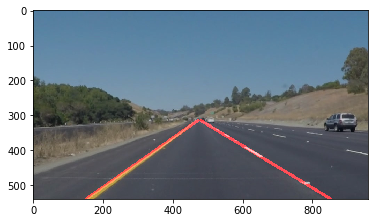

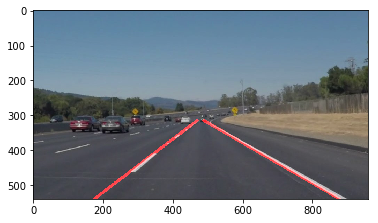

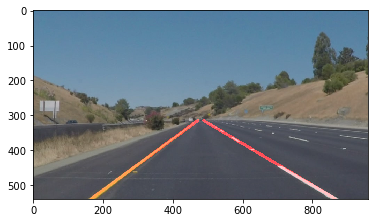

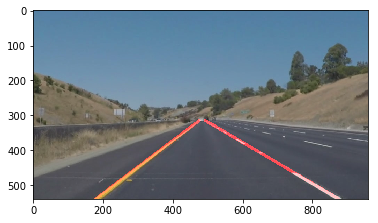

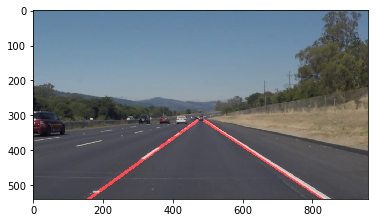

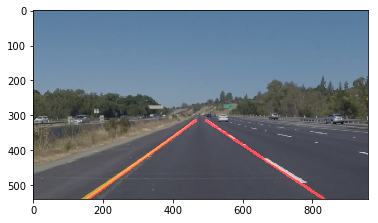

In [37]:
final_imgset = []

for i in range(0,6):
    final_img = weighted_img(hough_imgset[i], read_imgset[i])
    final_imgset.append(final_img)
    plt.figure()
    plt.imshow(final_img)

### Save the Images

The images from test_images are saved in the folder test_images_output with the lane lines annotated on top and in the format .png

In [38]:
# test_imgs = os.listdir("test_images/")

for i in range(0,6):
    fname = test_imgs[i].split('.')[0] + '_lanelines.png'
    plt.imsave(os.path.join('test_images_output', fname), final_imgset[i])

## Pipeline Overview

1. Grayscale
2. Gaussian Blur
3. Canny Edges
4. Region Of Interest
5. Hough Transform

## Lane Lines on a Video

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [40]:
def process_image(image):
    
    gray = grayscale(image)
    
    gaussian = gaussian_blur(gray, 7)
    
    canny_img = canny(gaussian, 50, 150)
    
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    region = region_of_interest(canny_img, vertices)
    
    hough_img = hough_lines(region, rho=1, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    
    result = weighted_img(hough_img, image)
    
    return result

In [41]:
white_output = "test_videos_output/solidWhiteRight.mp4"
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 14.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1min 28s, sys: 2.95 s, total: 1min 31s
Wall time: 15.8 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [47]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[0.67619047619047623, 0.69696969696969702, 0.69696969696969702, 0.66666666666666663, 0.67647058823529416, 0.71698113207547165] [-26.371428571428623, -32.0, -30.606060606060623, -19.0, -27.264705882352928, -44.264150943396203]
[-0.60322580645161294, -0.62937062937062938, -0.62790697674418605, -0.60526315789473684, -0.61538461538461542, -0.60439560439560436, -0.625, -0.59183673469387754, -0.67213114754098358, -0.6097560975609756] [600.94193548387102, 616.67132867132864, 615.04651162790697, 600.42105263157896, 612.84615384615381, 602.06593406593402, 616.375, 595.79591836734699, 633.47540983606564, 601.70731707317077]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  2%|▏         | 3/126 [00:00<00:05, 21.47it/s]

[0.67619047619047623, 0.69696969696969702, 0.69696969696969702, 0.66666666666666663, 0.67647058823529416, 0.71698113207547165] [-26.371428571428623, -32.0, -30.606060606060623, -19.0, -27.264705882352928, -44.264150943396203]
[-0.60322580645161294, -0.62937062937062938, -0.62790697674418605, -0.60526315789473684, -0.61538461538461542, -0.60439560439560436, -0.625, -0.59183673469387754, -0.67213114754098358, -0.6097560975609756] [600.94193548387102, 616.67132867132864, 615.04651162790697, 600.42105263157896, 612.84615384615381, 602.06593406593402, 616.375, 595.79591836734699, 633.47540983606564, 601.70731707317077]
[0.69852941176470584, 0.64383561643835618, 0.72307692307692306, 0.6495726495726496, 0.65853658536585369, 0.71999999999999997] [-33.602941176470608, -2.6712328767123381, -49.86153846153843, -6.5470085470085451, -14.390243902439067, -49.199999999999932]
[-0.62790697674418605, -0.60383386581469645, -0.62637362637362637, -0.60185185185185186, -0.62601626016260159, -0.605042016806

[0.71875, 0.64444444444444449, 0.72413793103448276, 0.65517241379310343, 0.6506024096385542] [-49.4375, -3.3333333333333712, -54.068965517241395, -11.344827586206861, -9.2048192771084132]
[-0.64682539682539686, -0.62, -0.62385321100917435, -0.6495726495726496, -0.61940298507462688, -0.64532019704433496, -0.61971830985915488, -0.62121212121212122, -0.84090909090909094] [623.96825396825398, 608.20000000000005, 609.97247706422013, 625.35897435897436, 607.37313432835822, 622.53694581280786, 606.78873239436621, 609.93939393939399, 704.0454545454545]
[0.6428571428571429, 0.65000000000000002, 0.6428571428571429] [-3.2857142857143344, -9.6499999999999773, -2.3571428571428896]
[-0.62254901960784315, -0.64951768488745976, -0.64864864864864868, -0.625, -0.6470588235294118, -0.62318840579710144, -0.625] [609.59313725490199, 625.68488745980699, 624.91891891891896, 611.25, 625.76470588235293, 609.04347826086951, 610.875]
[0.62376237623762376, 0.67441860465116277, 0.6292134831460674, 0.62790697674418


  6%|▌         | 7/126 [00:00<00:05, 23.48it/s]

[0.77611940298507465, 0.67441860465116277, 0.70454545454545459] [-82.19402985074629, -20.767441860465112, -38.704545454545496]
[-0.65019011406844107, -0.65277777777777779, -0.625, -0.62666666666666671, -0.61224489795918369, -0.65277777777777779, -0.97499999999999998, -0.65172413793103445, -0.625] [628.37642585551339, 627.83333333333326, 613.0, 612.82666666666671, 605.79591836734699, 629.69444444444446, 764.47499999999991, 628.24137931034488, 613.875]
[0.66666666666666663, 0.62745098039215685] [-17.666666666666629, 2.0784313725490051]
[-0.62546816479400746, -0.65098039215686276, -0.62589928057553956, -0.65238095238095239, -0.6607142857142857, -0.63636363636363635, -0.66666666666666663, -0.95348837209302328, -0.62903225806451613] [613.05617977528095, 628.48627450980393, 612.73381294964031, 628.25714285714287, 630.71428571428578, 615.81818181818176, 632.33333333333326, 753.60465116279079, 614.48387096774195]
[0.67346938775510201, 0.6428571428571429, 0.65116279069767447, 0.625, 0.666666666


  8%|▊         | 10/126 [00:00<00:04, 24.59it/s]

[0.68085106382978722, 0.61111111111111116, 0.66666666666666663, 0.62745098039215685, 0.64912280701754388] [-26.446808510638277, 11.666666666666629, -18.0, -0.039215686274530981, -9.3333333333333712]
[-0.6742424242424242, -0.65048543689320393, -0.64150943396226412, -0.67455621301775148, -0.64473684210526316, -0.65909090909090906, -0.66666666666666663, -0.64000000000000001, -0.63793103448275867, -0.65000000000000002, -0.67391304347826086, -1.0] [634.71212121212125, 621.747572815534, 617.45283018867917, 636.13017751479288, 617.01315789473688, 624.06818181818176, 632.0, 617.16000000000008, 615.5344827586207, 618.79999999999995, 634.47826086956525, 773.0]
[0.67796610169491522, 0.61538461538461542, 0.57499999999999996, 0.62903225806451613, 0.64516129032258063, 0.67241379310344829] [-25.118644067796595, 9.2307692307692264, 33.725000000000023, -0.95161290322579362, -6.8709677419354875, -20.620689655172441]
[-0.62790697674418605, -0.67114093959731547, -0.62941176470588234, -0.67289719626168221,


 10%|█         | 13/126 [00:00<00:04, 25.24it/s]

[0.62376237623762376, 0.67021276595744683, 0.62, 0.676056338028169] [3.5742574257425872, -21.670212765957444, 5.4599999999999795, -24.718309859154942]
[-0.67491166077738518, -0.64919354838709675, -0.64814814814814814, -0.90566037735849059, -0.67428571428571427, -0.67924528301886788, -0.69565217391304346, -0.63934426229508201, -0.64754098360655743] [636.53710247349818, 621.11693548387098, 620.66666666666663, 729.79245283018872, 637.18285714285707, 637.50943396226421, 638.26086956521738, 617.91803278688531, 621.70491803278696]
[0.62015503875968991, 0.66935483870967738, 0.67213114754098358, 0.61904761904761907] [5.7131782945736518, -21.491935483870975, -22.70491803278685, 7.619047619047592]
[-0.65048543689320393, -0.67757009345794394, -0.64601769911504425, -0.67615658362989328, -0.6428571428571429, -0.6811594202898551, -0.65714285714285714, -0.65000000000000002] [622.5825242718447, 639.28037383177571, 620.69026548672571, 637.39501779359432, 618.92857142857144, 638.71014492753625, 623.6857


 13%|█▎        | 17/126 [00:00<00:04, 25.56it/s]

[0.64761904761904765, 0.61946902654867253, 0.64406779661016944, 0.65048543689320393, 0.63157894736842102, 0.70175438596491224, 0.61971830985915488, 0.67924528301886788, 0.63043478260869568] [-6.0, 5.2566371681416513, -9.7288135593220204, -7.1067961165049383, -1.6842105263157805, -38.947368421052602, 4.4225352112677001, -24.471698113207538, -2.5652173913043725]
[-0.64928909952606639, -0.69999999999999996, -0.69999999999999996, -0.66216216216216217, -0.69135802469135799, -0.63414634146341464, -0.96078431372549022, -0.67796610169491522, -0.6428571428571429, -0.95454545454545459, -0.70454545454545459] [623.70616113744074, 647.09999999999991, 645.70000000000005, 626.81081081081084, 643.08641975308637, 614.56097560975604, 754.07843137254895, 628.49152542372883, 620.42857142857144, 752.4545454545455, 642.59090909090912]
[0.65079365079365081, 0.66666666666666663, 0.61428571428571432, 0.64615384615384619, 0.625, 0.66666666666666663, 0.65853658536585369, 0.61764705882352944, 0.66666666666666663]

 [26.767441860465112]
[-0.67307692307692313, -0.70036101083032487, -0.67412140575079871, -0.66666666666666663, -0.70731707317073167, -0.045454545454545456, -0.67307692307692313, -0.6811594202898551] [631.34615384615381, 647.25631768953065, 630.70287539936101, 628.66666666666663, 649.02439024390242, 518.13636363636363, 632.34615384615381, 643.26086956521738]
[0.60194174757281549, 0.66666666666666663, 0.69387755102040816, 0.59999999999999998] [15.776699029126235, -18.666666666666629, -34.897959183673493, 16.0]
[-0.70143884892086328, -0.67412140575079871, -0.70342205323193918, -0.67105263157894735, -0.67368421052631577, -0.93877551020408168] [646.72302158273374, 630.6805111821086, 648.73384030418254, 629.26315789473688, 631.47368421052624, 742.87755102040819]
[0.66666666666666663] 


 18%|█▊        | 23/126 [00:00<00:04, 23.48it/s]

[-19.0]
[-0.676056338028169, -0.70149253731343286, -0.67507886435331232, -0.67346938775510201, -0.70542635658914732, -0.70121951219512191] [630.94366197183103, 646.73134328358208, 629.81072555205049, 631.0408163265306, 649.04651162790697, 646.21341463414637]
[0.63414634146341464, 0.61904761904761907, 0.65000000000000002, 0.6097560975609756, 0.63636363636363635] [-0.19512195121950526, 3.9047619047618696, -9.1999999999999886, 8.7804878048780779, -6.0909090909090651]
[-0.67625899280575541, -0.70329670329670335, -0.6759581881533101, -0.70967741935483875, -0.92957746478873238, -0.70454545454545459] [630.29496402877703, 646.30769230769238, 629.2543554006968, 649.0, 737.02816901408448, 645.9545454545455]
[0.61538461538461542, 0.63829787234042556, 0.62, 0.66666666666666663] [6.2307692307692264, -1.8297872340425556, 2.5, -21.333333333333314]
[-0.70329670329670335, -0.67368421052631577, -0.70114942528735635, -0.67272727272727273, -0.67346938775510201, -0.69999999999999996] [645.60439560439568, 6


 24%|██▍       | 30/126 [00:01<00:03, 26.17it/s]

[0.64864864864864868, 0.59999999999999998, 0.58139534883720934, 0.57999999999999996, 0.60784313725490191, 0.64912280701754388, 0.64912280701754388] [-8.4864864864865126, 18.0, 32.395348837209269, 34.520000000000039, 12.84313725490199, -9.1578947368420813, -7.8070175438596721]
[-0.70040485829959509, -0.67407407407407405, -0.67441860465116277, -0.70149253731343286, -1.0, -0.6875, -0.84782608695652173, -0.69047619047619047, -0.70652173913043481] [647.9635627530364, 631.34814814814808, 632.39534883720921, 649.23880597014931, 769.0, 635.4375, 707.91304347826087, 633.28571428571422, 649.1521739130435]
[0.59999999999999998, 0.62809917355371903, 0.62676056338028174, 0.60122699386503065, 0.63076923076923075] [16.0, 5.3719008264462218, 5.8943661971831034, 15.932515337423297, 2.0923076923077133]
[-0.67567567567567566, -0.70258620689655171, -0.67391304347826086, -0.81034482758620685, -0.68888888888888888, -0.70440251572327039, -0.8125, -0.69747899159663862] [631.91891891891896, 649.00862068965512,


 27%|██▋       | 34/126 [00:01<00:03, 27.51it/s]

[-0.75438596491228072, -0.7276785714285714, -0.67788461538461542, -0.86206896551724133, -0.67630057803468213, -0.72674418604651159, -0.75308641975308643, -0.69047619047619047, -0.875] [661.57894736842104, 657.33928571428578, 634.25961538461536, 710.68965517241372, 634.71098265895955, 657.98837209302326, 659.80246913580254, 637.54761904761904, 717.125]
[-0.75438596491228072, -0.7276785714285714, -0.67788461538461542, -0.86206896551724133, -0.67630057803468213, -0.72674418604651159, -0.75308641975308643, -0.69047619047619047, -0.875] [661.57894736842104, 657.33928571428578, 634.25961538461536, 710.68965517241372, 634.71098265895955, 657.98837209302326, 659.80246913580254, 637.54761904761904, 717.125]
[0.58536585365853655] [20.756097560975661]
[-0.78195488721804507, -0.72727272727272729, -0.72727272727272729, -0.70796460176991149, -0.71153846153846156, -0.71153846153846156, -0.78125, -0.71111111111111114, -0.70886075949367089, -0.7142857142857143, -0.70588235294117652, -0.7142857142857143


 30%|███       | 38/126 [00:01<00:03, 28.76it/s]

[0.59433962264150941, 0.625, 0.62376237623762376, 0.59999999999999998] [14.84905660377359, 0.875, 2.702970297029708, 12.0]
[-0.75886524822695034, -0.72641509433962259, -0.7544642857142857, -0.72670807453416153, -0.7142857142857143, -0.72093023255813948, -0.86440677966101698, -0.79629629629629628, -0.7142857142857143] [666.20567375886526, 647.46226415094338, 665.75, 648.40993788819878, 643.71428571428578, 645.55813953488371, 709.16949152542372, 674.74074074074076, 657.0]



 33%|███▎      | 41/126 [00:01<00:03, 28.14it/s]

[0.62121212121212122, 0.61940298507462688, 0.59999999999999998, 0.59999999999999998, 0.59420289855072461] [4.363636363636374, 4.6119402985074771, 10.400000000000034, 10.600000000000023, 13.869565217391312]
[-0.70289855072463769, -0.75510204081632648, -0.70666666666666667, -0.75438596491228072, -0.69999999999999996, -0.7807017543859649, -0.77500000000000002, -0.80392156862745101, -0.7021276595744681] [641.32608695652175, 664.10204081632651, 641.12, 664.73684210526312, 634.20000000000005, 667.09649122807014, 671.57500000000005, 678.0980392156863, 640.51063829787233]
[0.61904761904761907, 0.57407407407407407, 0.57851239669421484, 0.61739130434782608, 0.61855670103092786, 0.58490566037735847, 0.56818181818181823] [4.380952380952408, 30.518518518518533, 26.157024793388473, 6.5652173913043725, 4.185567010309228, 22.11320754716985, 33.227272727272691]
[-0.75423728813559321, -0.70319634703196343, -0.702247191011236, -0.71052631578947367, -0.86363636363636365, -0.75454545454545452, -0.782608695


 35%|███▍      | 44/126 [00:01<00:03, 26.75it/s]

[-0.7008928571428571, -0.75355450236966826, -0.75697211155378485, -0.70053475935828879, -0.7678571428571429, -0.7142857142857143, -0.72499999999999998, -0.75206611570247939] [638.22767857142856, 663.18957345971558, 663.90039840637451, 639.08021390374336, 667.0, 641.85714285714289, 645.04999999999995, 663.7355371900826]
[-0.7008928571428571, -0.75355450236966826, -0.75697211155378485, -0.70053475935828879, -0.7678571428571429, -0.7142857142857143, -0.72499999999999998, -0.75206611570247939] [638.22767857142856, 663.18957345971558, 663.90039840637451, 639.08021390374336, 667.0, 641.85714285714289, 645.04999999999995, 663.7355371900826]


[0.59999999999999998] [13.600000000000023]
[-0.70142180094786732, -0.78106508875739644, -0.77083333333333337, -0.8125, -0.782258064516129, -0.79166666666666663, -0.77027027027027029, -0.7052023121387283, -0.76666666666666672, -0.77419354838709675, -0.71084337349397586] [639.70616113744074, 673.04142011834324, 666.72916666666674, 681.4375, 674.66935483870964, 672.16666666666663, 668.54054054054052, 641.95953757225436, 667.10000000000002, 670.32258064516122, 642.25301204819277]
[0.58333333333333337, 0.61363636363636365, 0.59090909090909094, 0.60465116279069764] [24.0, 10.295454545454561, 19.954545454545439, 9.5348837209302815]
[-0.75384615384615383, -0.70050761421319796, -0.75257731958762886, -0.75510204081632648, -0.7021276595744681, -0.7142857142857143, -0.75510204081632648] [663.13846153846157, 639.57360406091368, 663.78350515463922, 663.10204081632651, 639.10638297872333, 642.85714285714289, 663.40816326530603]
[0.59615384615384615, 0.59259259259259256, 0.61702127659574468] [22.57692


 40%|███▉      | 50/126 [00:01<00:03, 22.92it/s]

[0.59375, 0.6166666666666667, 0.57499999999999996, 0.62790697674418605] [17.96875, 9.5, 30.450000000000045, 1.7906976744185954]
[-0.70270270270270274, -0.76106194690265483, -0.75287356321839083, -0.71250000000000002, -0.77419354838709675, -0.8035714285714286, -0.7678571428571429, -0.72093023255813948, -0.69047619047619047, -0.810126582278481, -0.74137931034482762, -0.77192982456140347] [640.59459459459458, 666.15044247787614, 664.59770114942535, 642.4375, 668.29032258064512, 678.21428571428578, 668.19642857142856, 645.02325581395348, 635.97619047619048, 686.03797468354423, 660.05172413793105, 668.47368421052624]
[0.59493670886075944, 0.62337662337662336, 0.59459459459459463, 0.61904761904761907] [17.07594936708864, 4.6623376623376771, 17.891891891891873, 5.190476190476204]
[-0.72687224669603523, -0.75294117647058822, -0.7583333333333333, -0.72180451127819545, -0.72670807453416153, -0.72307692307692306, -0.75392670157068065, -0.78048780487804881] [646.28193832599118, 662.98823529411766,


 43%|████▎     | 54/126 [00:02<00:03, 22.93it/s]

 [9.1340206185566331, 15.117647058823536, 20.090909090909065, 0.45454545454549589, -6.8644067796610102, 51.462686567164155, 5.1836734693877133]
[-0.703125, -0.75342465753424659, -0.75396825396825395, -0.74603174603174605, -0.70588235294117652, -0.69999999999999996, -0.7678571428571429, -0.71153846153846156, -0.74509803921568629] [638.546875, 663.7534246575342, 662.77777777777783, 659.60317460317458, 639.0, 635.59999999999991, 665.33928571428578, 641.65384615384619, 653.23529411764707]
[0.55405405405405406, 0.63265306122448983, 0.57692307692307687, 0.59183673469387754, 0.050000000000000003, 0.66666666666666663, 0.58108108108108103, 0.63265306122448983] [42.918918918918905, -2.9183673469387941, 33.615384615384642, 18.959183673469397, 474.10000000000002, -19.333333333333314, 25.797297297297348, -1.9183673469387941]
[-0.75355450236966826, -0.70833333333333337, -0.70081967213114749, -0.74683544303797467, -0.75289575289575295, -0.7142857142857143, -0.69811320754716977, -0.70731707317073167, 


 48%|████▊     | 60/126 [00:02<00:03, 21.31it/s]

[0.59999999999999998, 0.66666666666666663] [16.400000000000034, -19.333333333333314]
[-0.70143884892086328, -0.75113122171945701, -0.75, -0.75396825396825395, -0.70168067226890751, -0.70454545454545459, -0.75155279503105588, -0.75] [637.60431654676256, 661.43438914027149, 660.25, 663.53174603174602, 638.63865546218483, 638.38636363636374, 661.00621118012418, 663.0]
[0.59999999999999998, 0.60869565217391308, 0.61403508771929827, 0.59090909090909094, 0.70731707317073167] [22.0, 10.652173913043441, 9.6315789473683822, 20.818181818181813, -46.463414634146318]
[-0.70036101083032487, -0.75132275132275128, -0.75348837209302322, -0.70512820512820518, -0.74193548387096775, -0.7558139534883721, -0.70270270270270274, -0.70253164556962022] [636.75090252707582, 660.71428571428578, 662.08372093023252, 637.94871794871801, 657.45161290322585, 664.06976744186045, 638.78378378378375, 637.17088607594928]
[0.61538461538461542, 0.5714285714285714, 0.57627118644067798, 0.56896551724137934, 0.576923076923076


 52%|█████▏    | 65/126 [00:02<00:04, 14.09it/s]

[0.62096774193548387, 0.59848484848484851, 0.62204724409448819, 0.59793814432989689] [10.362903225806463, 17.643939393939377, 8.6299212598424901, 18.814432989690715]
[-0.70056497175141241, -0.72758620689655173, -0.72826086956521741, -0.6962962962962963, -0.72463768115942029, -0.6987951807228916, -0.7142857142857143, -0.71153846153846156] [636.03954802259886, 651.50344827586207, 652.60869565217399, 633.69629629629628, 650.31884057971013, 633.03614457831327, 638.71428571428578, 638.61538461538464]
[0.62068965517241381, 0.59459459459459463, 0.59731543624161076, 0.625] [10.413793103448256, 21.648648648648646, 18.516778523489961, 7.625]
[-0.67759562841530052, -0.72586872586872586, -0.72727272727272729, -0.72916666666666663, -0.72916666666666663, -0.67630057803468213, -0.70731707317073167] [630.15300546448088, 652.20463320463318, 646.09090909090912, 652.75, 648.4375, 629.15028901734104, 638.63414634146341]
[0.59523809523809523, 0.63888888888888884, 0.6506024096385542, 0.59836065573770492] [2


 55%|█████▍    | 69/126 [00:03<00:03, 15.30it/s]

[0.61363636363636365] [12.863636363636374]
[-0.72661870503597126, -0.69512195121951215, -0.72758620689655173, -0.69999999999999996, -0.69871794871794868, -0.69696969696969702, -0.7265625, -0.72307692307692306, -0.69620253164556967] [653.53237410071938, 635.68292682926824, 652.95862068965516, 638.5, 636.12179487179492, 634.87878787878788, 646.953125, 653.18461538461543, 636.69620253164567]
[0.5957446808510638, 0.625] [20.617021276595779, 3.0]
[-0.72695035460992907, -0.72307692307692306, -0.6964285714285714, -0.69999999999999996, -0.69565217391304346, -0.71111111111111114, -0.67500000000000004, -0.77922077922077926] [653.85815602836874, 652.2461538461539, 635.80357142857144, 638.29999999999995, 634.695652173913, 641.08888888888896, 626.17499999999995, 675.44155844155853]
[0.60344827586206895, 0.61904761904761907, 0.65217391304347827] [15.827586206896569, 5.9047619047618696, -8.4347826086956843]
[-0.72631578947368425, -0.69402985074626866, -0.72352941176470587, -0.69863013698630139, -0.72


 59%|█████▊    | 74/126 [00:03<00:03, 14.94it/s]

[0.625, 0.54545454545454541, 0.66153846153846152] [8.75, 54.181818181818187, -14.030769230769238]
[-0.6776859504132231, -0.67420814479638014, -0.72413793103448276, -0.72566371681415931, -0.79545454545454541, -0.68181818181818177, -0.72413793103448276, -0.72580645161290325] [630.36363636363637, 630.36651583710409, 652.41379310344826, 653.46902654867256, 677.72727272727275, 631.4545454545455, 651.68965517241384, 654.4677419354839]
[0.64814814814814814, 0.5901639344262295, 0.58333333333333337, 0.57627118644067798, 0.64814814814814814, 0.67441860465116277] [-4.8518518518518476, 24.573770491803259, 29.833333333333314, 34.830508474576277, -5.8703703703703809, -23.139534883720899]
[-0.67532467532467533, -0.7265625, -0.72674418604651159, -0.72649572649572647, -0.67500000000000004, -0.68888888888888888, -0.68354430379746833, -0.72916666666666663] [630.51948051948057, 653.5, 654.5, 653.0598290598291, 626.17499999999995, 634.13333333333333, 632.63291139240505, 652.47916666666663]
[0.625, 0.640625


 60%|██████    | 76/126 [00:03<00:03, 15.61it/s]

[0.64748201438848918, 0.59589041095890416, 0.59859154929577463, 0.60465116279069764, 0.66000000000000003] [-3.9352517985611257, 24.643835616438309, 23.373239436619713, 17.372093023255843, -14.860000000000014]
[-0.72602739726027399, -0.67727272727272725, -0.72758620689655173, -0.68571428571428572, -0.68888888888888888, -0.7142857142857143, -0.68181818181818177, -0.69999999999999996] [655.0, 632.14090909090908, 654.41379310344826, 633.91428571428571, 634.26666666666665, 650.85714285714289, 630.0, 637.0]



 64%|██████▍   | 81/126 [00:04<00:03, 12.46it/s]

[0.64814814814814814, 0.59859154929577463, 0.64814814814814814, 0.59999999999999998, 0.64583333333333337, 0.5957446808510638] [-5.2407407407407618, 22.612676056338046, -5.4444444444444571, 21.0, -2.5416666666666856, 25.851063829787279]
[-0.726962457337884, -0.69672131147540983, -0.72641509433962259, -0.70129870129870131, -0.70078740157480313, -0.72289156626506024, -0.70833333333333337, -0.69767441860465118] [653.58703071672358, 636.88524590163934, 654.44339622641508, 636.48051948051943, 639.22047244094483, 652.2168674698795, 639.04166666666674, 634.97674418604652]
[0.65000000000000002, 0.59813084112149528, 0.63636363636363635, 0.63829787234042556, 0.60396039603960394] [-6.3500000000000227, 23.607476635514104, 4.818181818181813, 1.8297872340425556, 17.801980198019805]
[-0.72789115646258506, -0.70059880239520955, -0.72727272727272729, -0.69834710743801653, -0.6987951807228916, -0.7192982456140351, -0.70129870129870131, -0.70833333333333337] [654.00680272108843, 638.25149700598809, 654.63


 66%|██████▌   | 83/126 [00:04<00:03, 13.63it/s]

[0.66666666666666663, 0.64948453608247425, 0.77272727272727271] [-16.0, -9.927835051546424, -79.227272727272691]
[-0.7265625, -0.72222222222222221, -0.67914438502673802, -0.67431192660550454, -0.73809523809523814, -0.67901234567901236, -0.67272727272727273, -0.67701863354037262, -0.76595744680851063] [652.6796875, 650.66666666666663, 629.86631016042782, 629.03211009174311, 655.11904761904759, 629.32098765432102, 625.12727272727273, 630.7515527950311, 665.72340425531911]
[0.6607142857142857, 0.625, 0.72289156626506024, 0.67441860465116277, 0.70454545454545459] [-12.946428571428555, 3.25, -50.253012048192772, -19.720930232558146, -38.181818181818187]
[-0.72659176029962547, -0.69354838709677424, -0.69999999999999996, -0.72727272727272729, -0.69620253164556967, -0.71153846153846156, -0.69047619047619047, -0.69090909090909092, -0.70192307692307687, -0.72631578947368425] [651.77902621722842, 633.70967741935488, 636.89999999999998, 653.27272727272725, 632.98734177215192, 647.57692307692309, 6


 69%|██████▉   | 87/126 [00:04<00:03, 10.93it/s]

[0.6470588235294118, 0.61111111111111116, 0.64814814814814814, 0.64000000000000001, 0.61818181818181817, 0.66666666666666663, 0.65151515151515149, 0.66000000000000003] [-3.4117647058823763, 12.166666666666629, -5.6296296296296191, -5.4800000000000182, 9.0545454545454618, -16.666666666666629, -8.8787878787878753, -15.160000000000025]
[-0.72757475083056478, -0.67894736842105263, -0.67555555555555558, -0.72395833333333337, -0.72297297297297303, -0.68181818181818177, -0.67567567567567566, -0.72413793103448276] [651.77408637873759, 628.19473684210527, 628.5244444444445, 650.21354166666674, 651.16891891891896, 628.63636363636363, 627.86486486486478, 652.24137931034488]
[0.66666666666666663, 0.625, 0.69491525423728817, 0.64912280701754388, 0.67272727272727273, 0.62857142857142856] [-15.333333333333314, 4.375, -35.152542372881385, -6.0877192982456449, -22.890909090909076, 3.6571428571428442]
[-0.67680608365019013, -0.72682926829268291, -0.72571428571428576, -0.68181818181818177, -0.67796610169


 71%|███████   | 89/126 [00:04<00:03, 11.41it/s]

[0.62244897959183676, 0.63917525773195871, 0.65625, 0.62222222222222223, 0.62365591397849462, 0.64893617021276595, 0.6875, 0.59999999999999998] [5.1632653061224119, 2.2886597938144746, -10.3125, 4.7111111111111086, 5.0, -3.6170212765957217, -27.75, 18.400000000000034]
[-0.67656765676567654, -0.70318021201413428, -0.70348837209302328, -0.7142857142857143, -0.66666666666666663, -0.67357512953367871, -0.70542635658914732, -0.63829787234042556] [626.95379537953795, 643.10247349823317, 644.22674418604652, 646.42857142857144, 624.0, 626.6943005181347, 643.32558139534888, 610.25531914893622]
[0.62096774193548387, 0.64227642276422769, 0.64800000000000002, 0.62015503875968991, 0.62295081967213117] [5.3306451612903061, 0.38211382113814807, -4.73599999999999, 7.3565891472868543, 6.5573770491803316]
[-0.67532467532467533, -0.70034843205574915, -0.67475728155339809, -0.7052023121387283, -0.68656716417910446] [626.11688311688317, 642.35191637630669, 626.87864077669906, 643.22543352601156, 630.149253


 74%|███████▍  | 93/126 [00:05<00:02, 12.34it/s]

[0.64661654135338342, 0.61764705882352944, 0.61946902654867253, 0.61818181818181817, 0.64885496183206104] [-1.9248120300751452, 9.2941176470587834, 8.6017699115044479, 8.2181818181818471, -2.1450381679388784]
[-0.6737160120845922, -0.70270270270270274, -0.67441860465116277, -0.70222222222222219, -0.67073170731707321, -0.77777777777777779] [626.93051359516619, 643.81081081081084, 627.67441860465124, 644.73777777777775, 625.86585365853659, 675.88888888888891]
[0.64444444444444449, 0.6262626262626263, 0.64646464646464652, 0.647887323943662, 0.67441860465116277, 0.62264150943396224, 0.66666666666666663, 0.67441860465116277, 0.64383561643835618] [1.1777777777776919, 4.1717171717170913, -1.1515151515152411, -7.4929577464789077, -18.581395348837191, 5.6415094339622556, -15.333333333333314, -17.627906976744157, -6.0821917808219155]
[-0.70138888888888884, -0.67357512953367871, -0.67540983606557381, -0.66666666666666663, -0.70408163265306123] [645.3125, 629.20725388601034, 628.82950819672135, 62


 78%|███████▊  | 98/126 [00:05<00:01, 14.93it/s]

[0.6964285714285714, 0.66666666666666663, 0.67500000000000004, 0.67567567567567566] [-28.910714285714278, -16.666666666666629, -16.375, -20.648648648648646]
[-0.7010309278350515, -0.67391304347826086, -0.70110701107011075, -0.66666666666666663, -0.65714285714285714, -0.671875, -0.68918918918918914] [646.65979381443299, 631.08695652173913, 648.07380073800732, 628.66666666666663, 623.5428571428572, 630.390625, 636.41891891891896]
[0.66101694915254239, 0.60416666666666663, 0.63888888888888884, 0.63265306122448983, 0.66666666666666663] [-13.423728813559308, 21.8125, -0.36111111111108585, 4.4897959183673493, -12.0]
[-0.70181818181818179, -0.6745762711864407, -0.70629370629370625, -0.70344827586206893, -0.67307692307692313, -0.72448979591836737, -0.66176470588235292] [648.1854545454546, 631.09152542372885, 648.71328671328672, 649.44137931034481, 632.23076923076928, 650.4387755102041, 628.0]
[0.65000000000000002, 0.625, 0.6811594202898551, 0.67213114754098358, 0.72916666666666663] [-7.5500000


 79%|███████▉  | 100/126 [00:05<00:01, 14.56it/s]

[0.61403508771929827, 0.67307692307692313, 0.67088607594936711, 0.68965517241379315, 0.65517241379310343, 0.70588235294117652, 0.62962962962962965] [13.614035087719287, -17.307692307692321, -17.139240506329145, -30.206896551724185, -7.2758620689655231, -39.647058823529449, 4.5185185185185333]
[-0.67547169811320751, -0.72499999999999998, -0.6759581881533101, -0.7265625, -0.72222222222222221, -0.80392156862745101, -0.73913043478260865, -0.73999999999999999] [631.21509433962262, 653.54999999999995, 630.60627177700349, 655.3125, 652.11111111111109, 689.21568627450984, 659.08695652173913, 658.72000000000003]
[0.6705882352941176, 0.69841269841269837, 0.6470588235294118, 0.58695652173913049, 0.67796610169491522, 0.55555555555555558, 0.63793103448275867, 0.61111111111111116] [-16.988235294117601, -35.555555555555543, -1.941176470588232, 31.108695652173878, -20.406779661016913, 52.777777777777771, 5.4655172413792457, 12.055555555555543]
[-0.70338983050847459, -0.67708333333333337, -0.7007299270


 83%|████████▎ | 105/126 [00:06<00:01, 11.67it/s]

[0.6223776223776224, 0.64748201438848918, 0.62328767123287676, 0.65306122448979587] [6.8251748251748268, -1.2302158273381565, 7.0616438356164508, -4.5102040816326507]
[-0.70260223048327142, -0.67465753424657537, -0.67391304347826086, -0.70038910505836571, -0.70454545454545459, -0.66956521739130437] [646.60594795539032, 629.07876712328766, 629.97826086956525, 646.56031128404675, 646.40909090909099, 627.7217391304348]
[0.64516129032258063, 0.62307692307692308, 0.65322580645161288, 0.625, 0.62406015037593987, 0.64814814814814814] [0.58064516129036292, 6.5153846153846189, -4.4838709677419502, 4.25, 6.6766917293232382, -2.3518518518518476]
[-0.70110701107011075, -0.67474048442906576, -0.6706586826347305, -0.67455621301775148, -0.70078740157480313, -0.70155038759689925, -0.65217391304347827] [645.97047970479707, 629.41522491349474, 627.86826347305384, 630.21893491124263, 646.62204724409446, 645.47286821705427, 618.91304347826087]
[0.63013698630136983, 0.59999999999999998, 0.59615384615384615


 85%|████████▍ | 107/126 [00:06<00:01, 11.08it/s]

[0.5957446808510638, 0.6767676767676768, 0.61538461538461542, 0.54385964912280704] [23.021276595744723, -20.828282828282852, 9.4615384615384528, 52.771929824561369]
[-0.70143884892086328, -0.6733668341708543, -0.67474048442906576, -0.66972477064220182, -0.70040485829959509, -0.61363636363636365, -0.72093023255813948] [645.3201438848921, 629.4070351758794, 628.74048442906576, 627.0733944954128, 646.16194331983797, 601.56818181818176, 652.23255813953483]
[0.62393162393162394, 0.67924528301886788, 0.67441860465116277] [6.4188034188034067, -21.132075471698101, -22.744186046511629]
[-0.7007575757575758, -0.67039106145251393, -0.6733668341708543, -0.70256410256410251, -0.67164179104477617, -0.70124481327800825, -0.7191011235955056, -0.67567567567567566] [645.91666666666674, 628.26256983240228, 629.7537688442211, 645.91282051282042, 627.32835820895525, 646.99170124481327, 647.31460674157302, 628.8648648648649]
[0.62318840579710144, 0.60784313725490191, 0.64583333333333337, 0.61904761904761907


 89%|████████▉ | 112/126 [00:06<00:01, 12.17it/s]

[0.62, 0.70769230769230773, 0.65957446808510634, 0.64583333333333337, 0.69736842105263153, 0.6964285714285714, 0.70149253731343286] [9.3600000000000136, -39.0, -8.9787234042552768, -6.3541666666666856, -29.776315789473642, -33.803571428571388, -33.970149253731336]
[-0.67450980392156867, -0.73684210526315785, -0.70300751879699253, -0.70161290322580649, -0.67441860465116277, -0.71739130434782605, -0.67320261437908502] [630.61960784313726, 660.57894736842104, 647.66917293233087, 648.1532258064517, 630.04651162790697, 652.695652173913, 631.281045751634]
[0.6166666666666667, 0.66666666666666663, 0.62352941176470589, 0.65333333333333332, 0.64814814814814814, 0.6785714285714286, 0.68421052631578949, 0.67567567567567566] [11.033333333333303, -14.333333333333314, 7.6235294117647072, -10.733333333333348, -8.8148148148147811, -20.678571428571445, -22.263157894736878, -18.297297297297291]
[-0.67441860465116277, -0.70229007633587781, -0.66981132075471694, -0.72477064220183485, -0.7142857142857143, 


 92%|█████████▏| 116/126 [00:06<00:00, 12.93it/s]

[0.64444444444444449, 0.59595959595959591, 0.66666666666666663, 0.60344827586206895, 0.65671641791044777] [-0.46666666666669698, 25.858585858585911, -15.666666666666629, 19.517241379310349, -8.2835820895522261]
[-0.69957081545064381, -0.6737967914438503, -0.67741935483870963, -0.70305676855895194, -0.69387755102040816, -0.72093023255813948, -0.70967741935483875, -0.6875, -0.69999999999999996] [647.83261802575112, 631.78074866310158, 631.80645161290317, 648.06550218340612, 638.0, 653.83720930232562, 649.58064516129036, 634.625, 649.0]
[0.64655172413793105, 0.59999999999999998, 0.64406779661016944, 0.60273972602739723, 0.61904761904761907] [-1.4827586206896513, 22.600000000000023, -0.81355932203388193, 19.931506849315099, 9.2857142857142776]
[-0.70292887029288698, -0.67790262172284643, -0.70050761421319796, -0.75, -0.671875, -0.71186440677966101, -0.67500000000000004, -0.74390243902439024] [648.35983263598325, 632.55056179775283, 648.68020304568529, 666.75, 630.046875, 645.47457627118638


 94%|█████████▎| 118/126 [00:07<00:00, 11.58it/s]

[0.61538461538461542, 0.6517857142857143, 0.61739130434782608, 0.64601769911504425, 0.64912280701754388] [11.307692307692264, -6.8928571428571104, 8.7478260869564792, -1.0707964601770072, -5.3157894736842763]
[-0.6517857142857143, -0.70135746606334837, -0.69841269841269837, -0.74137931034482762, -0.70068027210884354, -0.69999999999999996, -0.65354330708661412, -0.70588235294117652] [626.64285714285711, 648.11312217194563, 639.06349206349205, 663.44827586206907, 640.71428571428578, 647.20000000000005, 626.41732283464569, 647.94117647058829]
[0.5977011494252874, 0.66129032258064513, 0.64383561643835618, 0.65000000000000002, 0.63636363636363635, 0.59999999999999998, 0.60416666666666663, 0.67241379310344829, 0.59999999999999998, 0.61363636363636365] [24.977011494252793, -17.080645161290306, 0.041095890410929314, -6.3000000000000114, -0.45454545454543904, 23.199999999999989, 20.25, -23.706896551724185, 22.400000000000034, 11.363636363636374]
[-0.70192307692307687, -0.67669172932330823, -0.7


 96%|█████████▌| 121/126 [00:07<00:00, 13.69it/s]

[0.67272727272727273, 0.62222222222222223, 0.67272727272727273, 0.69767441860465118, 0.61904761904761907] [-18.763636363636351, 4.7111111111111086, -19.109090909090924, -33.976744186046517, 7.9047619047618696]
[-0.67634854771784236, -0.72596153846153844, -0.72058823529411764, -0.72477064220183485, -0.68354430379746833, -0.6728395061728395, -0.68085106382978722, -0.72611464968152861, -0.70731707317073167] [632.33609958506224, 656.20192307692309, 653.86764705882354, 654.23853211009168, 633.70886075949375, 630.85185185185185, 632.02127659574467, 657.09554140127386, 649.7560975609756]
[0.63829787234042556, 0.609375, 0.60784313725490191] [-4.0212765957447232, 13.609375, 15.490196078431381]
[-0.67841409691629961, -0.70053475935828879, -0.70930232558139539, -0.68235294117647061, -0.70833333333333337, -0.68085106382978722, -0.70588235294117652, -0.67123287671232879, -0.70370370370370372, -0.66666666666666663] [633.29955947136568, 648.68449197860969, 649.53488372093022, 633.4588235294118, 650.2


 99%|█████████▉| 125/126 [00:07<00:00, 16.10it/s]

[0.6428571428571429, 0.59999999999999998, 0.66666666666666663, 0.6097560975609756, 0.60784313725490191, 0.6470588235294118, 0.61363636363636365] [-0.85714285714288962, 20.199999999999989, -15.333333333333314, 14.804878048780495, 15.764705882352985, -2.5294117647059124, 10.977272727272748]
[-0.72727272727272729, -0.6972111553784861, -0.69590643274853803, -0.69767441860465118, -0.72556390977443608, -0.72519083969465647, -0.69999999999999996] [657.5454545454545, 639.90039840637451, 638.87134502923982, 640.81395348837214, 657.74060150375931, 656.35114503816794, 638.39999999999998]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 44.5 s, sys: 1.86 s, total: 46.4 s
Wall time: 8.57 s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [52]:
challenge_output = 'test_videos_output/challenge.mp4'
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 86%|████████▌ | 215/251 [00:28<00:07,  4.73it/s]


100%|██████████| 251/251 [00:34<00:00,  7.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 3min 7s, sys: 7.33 s, total: 3min 14s
Wall time: 36.5 s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))